In [ ]:
import os
import cv2
import torch
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.models import resnet101, ResNet101_Weights
from torchvision.models.detection.retinanet import RetinaNet
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.ops.feature_pyramid_network import LastLevelMaxPool
from torchvision.models.detection.anchor_utils import AnchorGenerator
from collections import OrderedDict

#Configs
MODEL_PATH = "saved_model.pth"
TEST_DIR = "rsna_data/stage_2_test_images"
OUTPUT_DIR = "test_predictions"
RESIZE_TO = (768, 768)
SCORE_THRESH = 0.5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(OUTPUT_DIR, exist_ok=True)

#defining model loading
def get_model(num_classes=2):
    backbone = resnet101(weights=ResNet101_Weights.DEFAULT)
    modules = OrderedDict([
        ("conv1", backbone.conv1),
        ("bn1", backbone.bn1),
        ("relu", backbone.relu),
        ("maxpool", backbone.maxpool),
        ("layer1", backbone.layer1),
        ("layer2", backbone.layer2),
        ("layer3", backbone.layer3),
        ("layer4", backbone.layer4),
    ])
    backbone = torch.nn.Sequential(modules)
    return_layers = {"layer1": "0", "layer2": "1", "layer3": "2", "layer4": "3"}
    in_channels_list = [256, 512, 1024, 2048]
    out_channels = 256
    fpn_backbone = BackboneWithFPN(backbone, return_layers, in_channels_list, out_channels, extra_blocks=LastLevelMaxPool())
    anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
    aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
    anchor_generator = AnchorGenerator(sizes=anchor_sizes, aspect_ratios=aspect_ratios)
    model = RetinaNet(backbone=fpn_backbone, num_classes=num_classes, anchor_generator=anchor_generator)
    return model

#Loading saved model
model = get_model()
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()
print("Model loaded.")

#Defining prediction function
def predict_on_dicom(dcm_path):
    dcm = pydicom.dcmread(dcm_path)
    img = dcm.pixel_array.astype(np.float32)
    h_orig, w_orig = img.shape
    img_resized = cv2.resize(img, RESIZE_TO)
    img_resized = (img_resized - img_resized.min()) / (img_resized.max() - img_resized.min())
    img_tensor = torch.tensor(img_resized).unsqueeze(0).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        pred = model([img_tensor.squeeze(0)])[0]

    boxes = pred["boxes"].detach().cpu().numpy()
    scores = pred["scores"].detach().cpu().numpy()
    keep = scores > SCORE_THRESH
    return boxes[keep], scores[keep], img_resized

#predictions on test images
from tqdm import tqdm

test_files = [f for f in os.listdir(TEST_DIR) if f.endswith(".dcm")]
print(f"Found {len(test_files)} test images.")
n = 20

for fname in tqdm(test_files[:n]):
    try:
        pid = fname.replace(".dcm", "")
        dcm_path = os.path.join(TEST_DIR, fname)
        boxes, scores, img = predict_on_dicom(dcm_path)

        if len(boxes) == 0:
            continue  #skip images with no predictions

        fig, ax = plt.subplots(1, figsize=(8, 8))
        ax.imshow(img, cmap='gray')
        for box, score in zip(boxes, scores):
            x1, y1, x2, y2 = box
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1 - 10, f"{score:.2f}", color='lime', fontsize=10)
        ax.set_title(f"Prediction for {pid}")
        ax.axis("off")
        plt.savefig(os.path.join(OUTPUT_DIR, f"{pid}_pred.png"), bbox_inches='tight')
        plt.close(fig)

    except Exception as e:
        print(f"Failed on {fname}: {e}")

print(f"✅ Predictions saved to {OUTPUT_DIR}/")


/tmp/ipykernel_3923393/3089717353.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))


Model loaded.
Found 3000 test images.


100%|██████████| 20/20 [00:51<00:00,  2.57s/it]

✅ Predictions saved to test_predictions/


/tmp/ipykernel_3923393/1002564248.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location='cpu'))


✅ Model loaded.


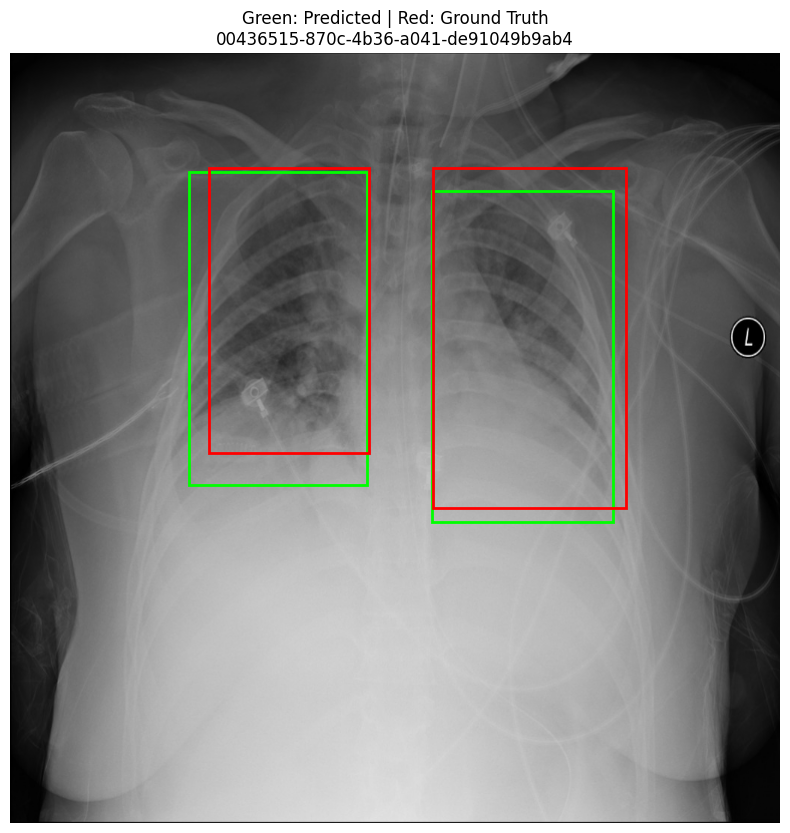

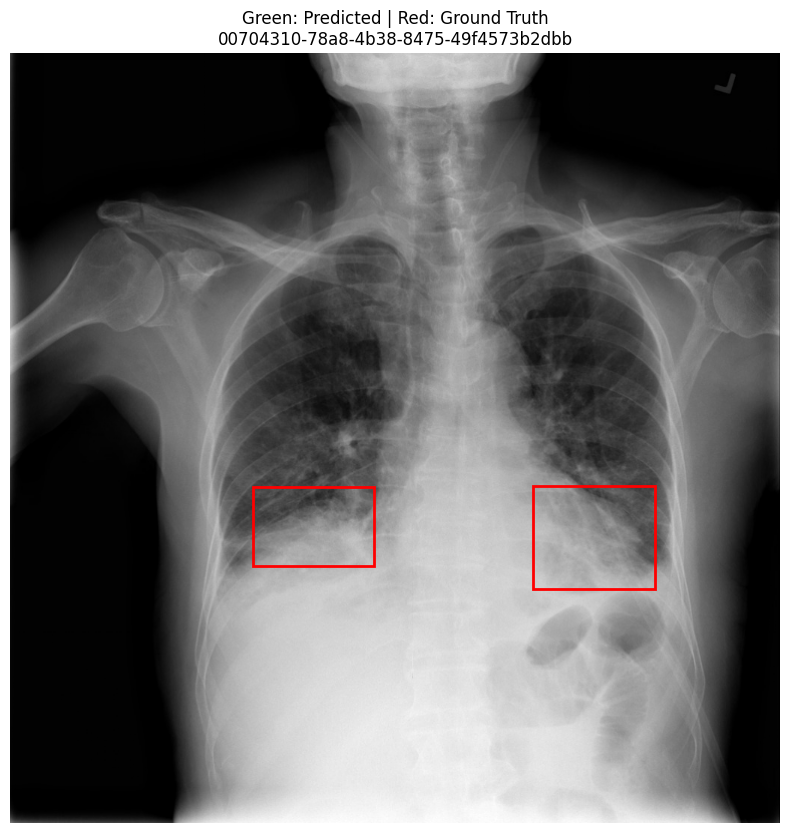

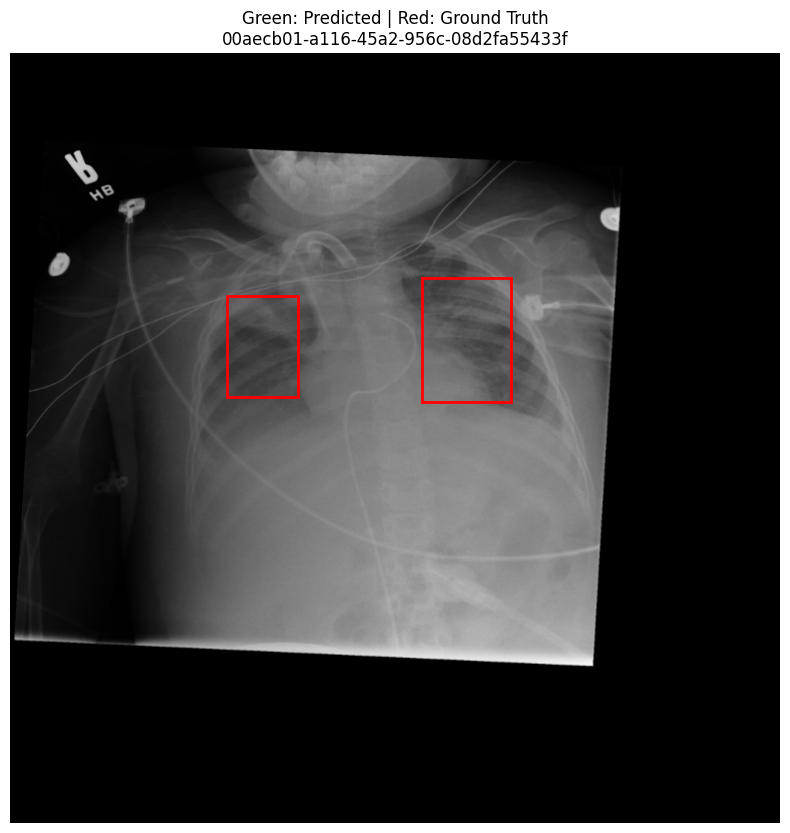

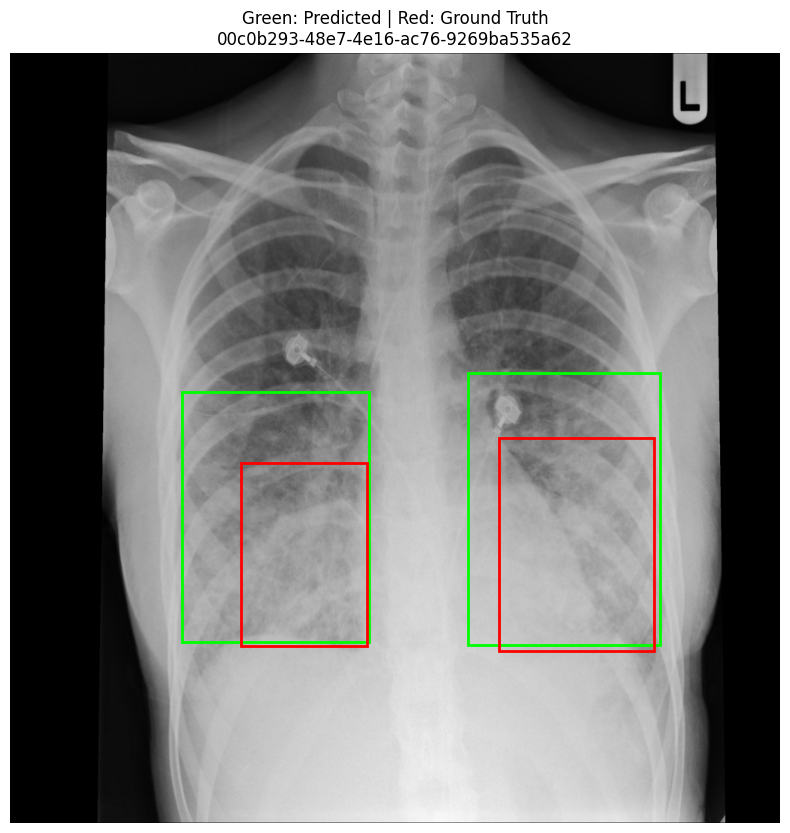

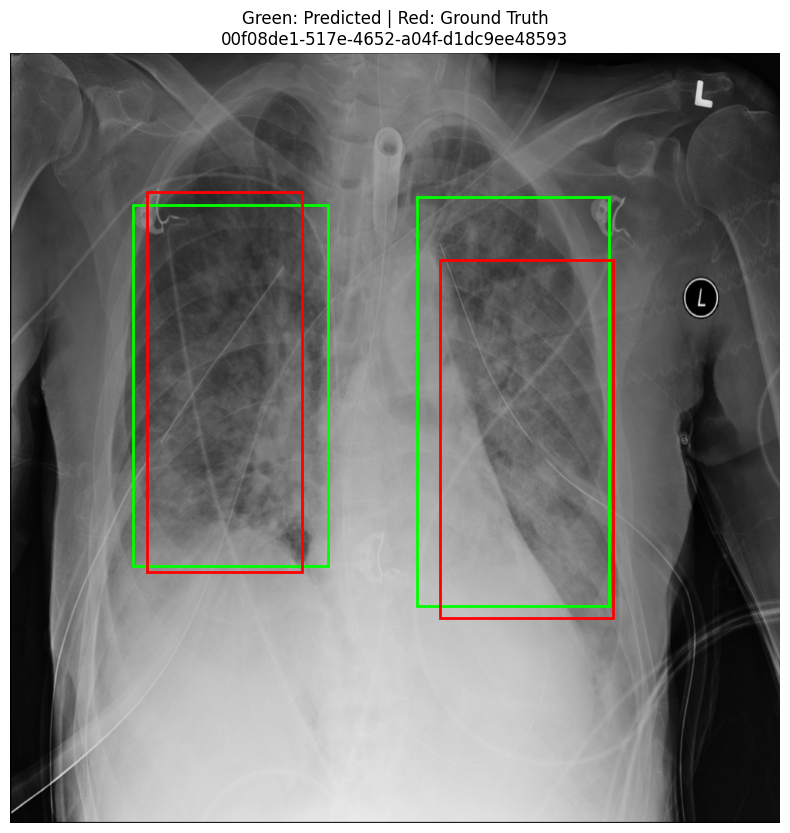

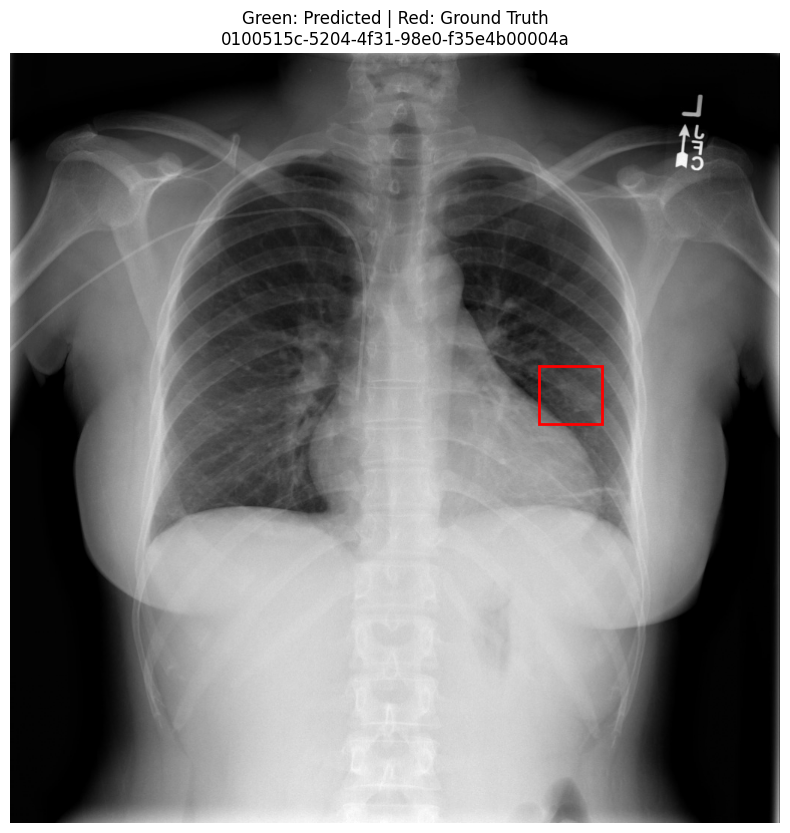

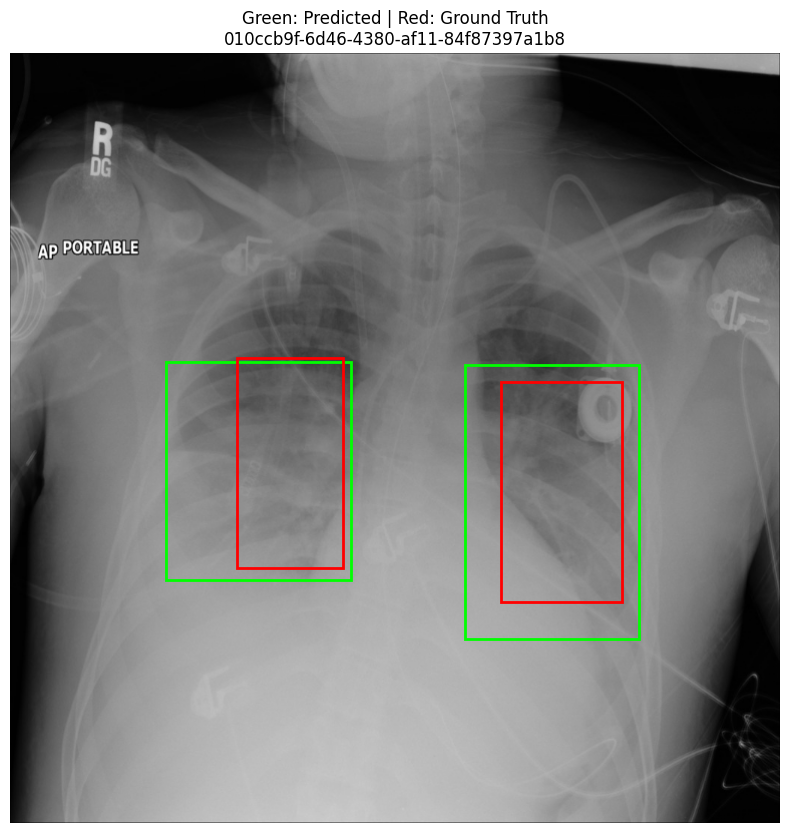

In [ ]:
import os
import torch
import cv2
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from tqdm import tqdm

#Configs
LABELS_CSV = "rsna_data/stage_2_train_labels.csv"
DICOM_DIR = "rsna_data/stage_2_train_images"
MODEL_PATH = "saved_model.pth"
RESIZE_TO = (768, 768)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SCORE_THRESH = 0.5

#Loading annotations
def load_gt_boxes(csv_path):
    df = pd.read_csv(csv_path)
    gt_dict = {}
    for _, row in df.iterrows():
        pid = row['patientId']
        if row['Target'] == 1:
            box = [row['x'], row['y'], row['x'] + row['width'], row['y'] + row['height']]
            if pid not in gt_dict:
                gt_dict[pid] = []
            gt_dict[pid].append(box)
    return gt_dict

#Load modeling
from torchvision.models import resnet101, ResNet101_Weights
from torchvision.models.detection.retinanet import RetinaNet
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.ops.feature_pyramid_network import LastLevelMaxPool
from torchvision.models.detection.anchor_utils import AnchorGenerator
from collections import OrderedDict

def get_model(num_classes=2):
    backbone = resnet101(weights=ResNet101_Weights.DEFAULT)
    modules = OrderedDict([
        ("conv1", backbone.conv1),
        ("bn1", backbone.bn1),
        ("relu", backbone.relu),
        ("maxpool", backbone.maxpool),
        ("layer1", backbone.layer1),
        ("layer2", backbone.layer2),
        ("layer3", backbone.layer3),
        ("layer4", backbone.layer4)
    ])
    backbone = torch.nn.Sequential(modules)

    return_layers = {"layer1": "0", "layer2": "1", "layer3": "2", "layer4": "3"}
    in_channels_list = [256, 512, 1024, 2048]
    out_channels = 256
    fpn_backbone = BackboneWithFPN(backbone, return_layers, in_channels_list, out_channels, extra_blocks=LastLevelMaxPool())

    anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
    aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
    anchor_generator = AnchorGenerator(sizes=anchor_sizes, aspect_ratios=aspect_ratios)

    model = RetinaNet(backbone=fpn_backbone, num_classes=num_classes, anchor_generator=anchor_generator)
    return model

#Loading model
model = get_model()
model.load_state_dict(torch.load(MODEL_PATH, map_location='cpu'))
model.to('cpu')
DEVICE = torch.device('cpu')
model.to(DEVICE)
model.eval()
print("✅ Model loaded.")

#Loading annotations
annotations = load_gt_boxes(LABELS_CSV)

#Predicting and visualize
def plot_prediction_with_ground_truth(pid):
    dcm_path = os.path.join(DICOM_DIR, f"{pid}.dcm")
    dcm = pydicom.dcmread(dcm_path)
    img = dcm.pixel_array.astype(np.float32)
    h_orig, w_orig = img.shape
    img_resized = cv2.resize(img, RESIZE_TO)
    img_norm = (img_resized - img_resized.min()) / (img_resized.max() - img_resized.min())
    img_tensor = torch.tensor(img_norm).unsqueeze(0).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        prediction = model([img_tensor.squeeze(0)])[0]

    boxes = prediction['boxes'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    keep = scores > SCORE_THRESH
    pred_boxes = boxes[keep]
    pred_scores = scores[keep]

    # Preparing ground truth
    gt_boxes = []
    for box in annotations.get(pid, []):
        x1, y1, x2, y2 = box
        x1 = x1 * RESIZE_TO[0] / w_orig
        x2 = x2 * RESIZE_TO[0] / w_orig
        y1 = y1 * RESIZE_TO[1] / h_orig
        y2 = y2 * RESIZE_TO[1] / h_orig
        gt_boxes.append([x1, y1, x2, y2])

    # Plot
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img_norm, cmap='gray')
    
    for box in pred_boxes:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)

    for box in gt_boxes:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    ax.set_title(f"Green: Predicted | Red: Ground Truth\n{pid}")
    plt.axis('off')
    plt.show()

#Running on a few samples
sample_ids = list(annotations.keys())[:7] 
for pid in sample_ids:
    plot_prediction_with_ground_truth(pid)
